In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

from matplotlib import colormaps

from datetime import date

pd.set_option('display.max_columns', None)

import matplotlib.colors as mcolors

In [2]:
# Cleaned data in Excel 
# Cleaned missing examiner info
# Cleaned date of testing
df = pd.read_excel('../data/bdi3_all_evals_clean.xlsx')

### Add 'Age at Testing' column for Q4

In [3]:
# Calculate the age at testing
df['Age at Testing'] = ((df['Date of Testing'] - df['Date of Birth']).dt.days) / 365
df.head()

,Child ID,Gender,Date of Birth,Location - Sub Level 1,Program Label,Date of Testing,Examiner,Adaptive Sum of Scaled Scores,Adaptive Developmental Quotient,Adaptive Percentile Rank,Adaptive 95% Confidence Interval,Adaptive RDI,Adaptive Z-Score,Adaptive T-Score,Adaptive NCE,Social-Emotional Sum of Scaled Scores,Social-Emotional Developmental Quotient,Social-Emotional Percentile Rank,Social-Emotional 95% Confidence Interval,Social-Emotional RDI,Social-Emotional Z-Score,Social-Emotional T-Score,Social-Emotional NCE,Communication Sum of Scaled Scores,Communication Developmental Quotient,Communication Percentile Rank,Communication 95% Confidence Interval,Communication RDI,Communication Z-Score,Communication T-Score,Communication NCE,Motor Sum of Scaled Scores,Motor Developmental Quotient,Motor Percentile Rank,Motor 95% Confidence Interval,Motor RDI,Motor Z-Score,Motor T-Score,Motor NCE,Cognitive Sum of Scaled Scores,Cognitive Developmental Quotient,Cognitive Percentile Rank,Cognitive 95% Confidence Interval,Cognitive RDI,Cognitive Z-Score,Cognitive T-Score,Cognitive NCE,BDI-3 Total Sum of Scaled Scores,BDI-3 Total Developmental Quotient,BDI-3 Total Percentile Rank,BDI-3 Total 90% Confidence Interval,BDI-3 Total 95% Confidence Interval,BDI-3 Total Z-Score,BDI-3 Total T-Score,BDI-3 Total NCE,Adaptive-Self Care RS,Adaptive-Self Care SS,Adaptive-Self Care PR,Adaptive-Self Care AE,Adaptive-Self Care RDI,Adaptive-Self Care CSS,Adaptive-Self Care CSS 90%,Adaptive-Self Care Z-Score,Adaptive-Self Care T-Score,Adaptive-Self Care NCE,Adaptive-Personal Responsibility RS,Adaptive-Personal Responsibility SS,Adaptive-Personal Responsibility PR,Adaptive-Personal Responsibility AE,Adaptive-Personal Responsibility RDI,Adaptive-Personal Responsibility CSS,Adaptive-Personal Responsibility CSS 90%,Adaptive-Personal Responsibility Z-Score,Adaptive-Personal Responsibility T-Score,Adaptive-Personal Responsibility NCE,Social Emotional-Adult Interaction RS,Social Emotional-Adult Interaction SS,Social Emotional-Adult Interaction PR,Social Emotional-Adult Interaction AE,Social Emotional-Adult Interaction RDI,Social Emotional-Adult Interaction CSS,Social Emotional-Adult Interaction CSS 90%,Social Emotional-Adult Interaction Z-Score,Social Emotional-Adult Interaction T-Score,Social Emotional-Adult Interaction NCE,Social Emotional-Peer Interaction RS,Social Emotional-Peer Interaction SS,Social Emotional-Peer Interaction PR,Social Emotional-Peer Interaction AE,Social Emotional-Peer Interaction RDI,Social Emotional-Peer Interaction CSS,Social Emotional-Peer Interaction CSS 90%,Social Emotional-Peer Interaction Z-Score,Social Emotional-Peer Interaction T-Score,Social Emotional-Peer Interaction NCE,Social Emotional-Self Concept / Social Role RS,Social Emotional-Self Concept / Social Role SS,Social Emotional-Self Concept / Social Role PR,Social Emotional-Self Concept / Social Role AE,Social Emotional-Self Concept / Social Role RDI,Social Emotional-Self Concept / Social Role CSS,Social Emotional-Self Concept / Social Role CSS 90%,Social Emotional-Self Concept / Social Role Z-Score,Social Emotional-Self Concept / Social Role T-Score,Social Emotional-Self Concept / Social Role NCE,Communication-Receptive Communication RS,Communication-Receptive Communication SS,Communication-Receptive Communication PR,Communication-Receptive Communication AE,Communication-Receptive Communication RDI,Communication-Receptive Communication CSS,Communication-Receptive Communication CSS 90%,Communication-Receptive Communication Z-Score,Communication-Receptive Communication T-Score,Communication-Receptive Communication NCE,Communication-Expressive Communication RS,Communication-Expressive Communication SS,Communication-Expressive Communication PR,Communication-Expressive Communication AE,Communication-Expressive Communication RDI,Communication-Expressive Communication CSS,Communication-Expressive Communication CSS 90%,Communication-Expressive Communication Z-Score,Communication-Expressive Comm

In [4]:
# Calculate age in months
df['months'] = (df['Age at Testing'] * 12).apply(int)

In [5]:
# Calculate age in years
df['years'] = (df['months'] / 12).apply(int)

### Clean RDI Column - Drop numerator & apply to all RDI columns

In [6]:
# Andri's function to clean RDI
def clean_rdi(column):
    months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    adaptive_rdi = df[column].str[0:-3]
    adaptive_rdi = [months[i] if i in months.keys() else i for i in adaptive_rdi] 
    adaptive_rdi = [0 if str(i)[0:1] == '<' else i for i in adaptive_rdi] 
    adaptive_rdi = [100 if str(i)[0:1] == '>' else i for i in adaptive_rdi] 
    adaptive_rdi = pd.to_numeric(adaptive_rdi)
    return adaptive_rdi

In [7]:
# Apply function to all columns with 'RDI'
for column in df.columns:
    if 'RDI' in column:
        df[column] = clean_rdi(column)

In [ ]:
df.head()

### String Cleaning

In [8]:
# Swtich to strings
df[['Gender', 'Location - Sub Level 1', 'Program Label', 'Examiner']] = df[['Gender', 'Location - Sub Level 1', 'Program Label', 'Examiner']].astype('string')
#df.info()

### Clean 'interval' columns by converting to strings

In [9]:
# Clean String Function
def string_clean(column):
    x = df[column].astype('string')
    return x

In [10]:
# Apply to all confidence intervals 
for column in df.columns:
    if 'Interval' in column:
        df[column] = string_clean(column)

### Switch 'Score' columns to numeric

In [11]:
def clean_z(column):
    z_col = df['Motor Z-Score'].astype(str).replace('– ', '-', regex=True)
    z_col =  z_col.replace('--', 0, regex=True)
    z_col =  z_col.apply(lambda x: float(x.replace('– ', '')) * -1 if '– ' in x else float(x))
    z_col =  z_col.fillna(0)
    return z_col

In [ ]:
#for column in df.columns:
    #if 'Z-Score' in column:
     #   df[column] = clean_z(column)

### Add Eligibility Column

In [12]:
# Using Amy's function to create column with eligibility
def filter(x):
    if x <= 70:
        return '40% delay'
    if (x >= 71 and x <= 78):
        return '25% delay'
    if x >= 79:
        return 'not eligible'
#applying the filter function to 'Salary' column 
df['Eligibility'] = df['BDI-3 Total Developmental Quotient'].apply(filter)

### Create BDI DF 

In [13]:
general = df.iloc[:, :7]

In [14]:
bdi_totals = [col for col in df.columns if 'BDI-3 Total' in col]
bdi = df[bdi_totals]
#bdi

In [15]:
df = df.drop_duplicates()

In [16]:
age_and_elig = df.iloc[:,-4:]
#age_and_elig 

In [17]:
bdi_df = pd.concat([general, bdi, age_and_elig], axis=1)
#bdi_df

# MVP
## 4. Does the child's age seem to impact their scoring?

In [24]:
bdi_dq_by_age = bdi_df.groupby(['years', 'months'])['BDI-3 Total Developmental Quotient'].mean()
#bdi_dq_by_age

In [19]:
bdi_by_age = pd.DataFrame(bdi_dq_by_age).reset_index()
#bdi_by_age

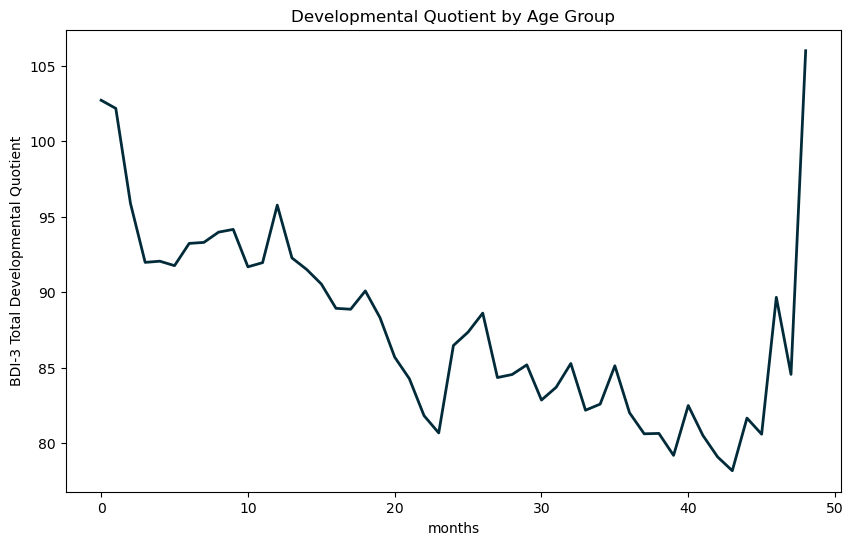

In [73]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=bdi_by_age, x='months', y='BDI-3 Total Developmental Quotient', color='#022B3A', linewidth=2)

plt.title('Developmental Quotient by Age Group');

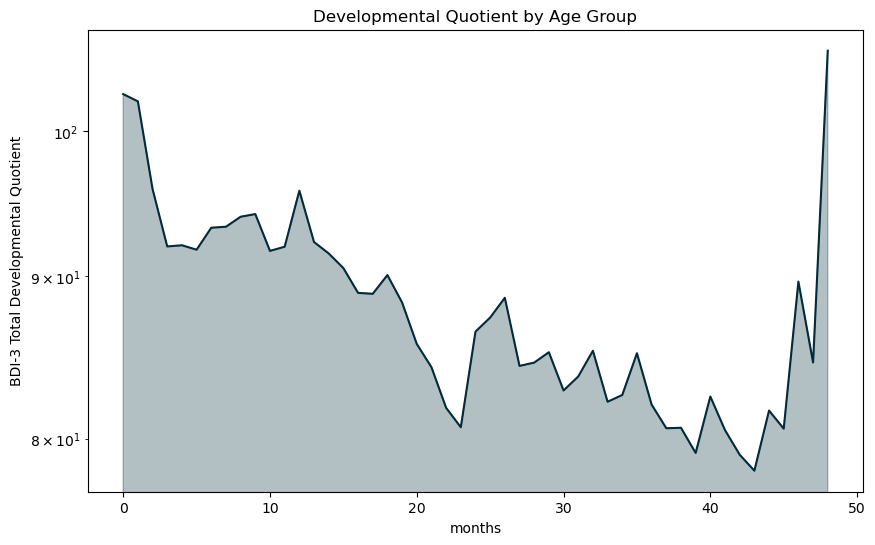

In [70]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=bdi_by_age, x='months', y='BDI-3 Total Developmental Quotient', color='#022B3A')
plt.fill_between(bdi_by_age['months'], bdi_by_age['BDI-3 Total Developmental Quotient'], color='#022B3A', alpha=0.3)

plt.yscale('log')  
plt.title('Developmental Quotient by Age Group')
plt.show()

In [23]:
dq_list = [col for col in df.columns if 'Quotient' in col]
dq_list

['Adaptive Developmental Quotient',
 'Social-Emotional Developmental Quotient',
 'Communication Developmental Quotient',
 'Motor Developmental Quotient',
 'Cognitive Developmental Quotient',
 'BDI-3 Total Developmental Quotient']

In [ ]:
list(colormaps)

### Heat Map

#### Note: Drop Week 48 and remove bdi-total

In [25]:
heat = df

In [26]:
heat = heat[['Adaptive Developmental Quotient', 'Cognitive Developmental Quotient', 'Communication Developmental Quotient', 'Motor Developmental Quotient', 'Social-Emotional Developmental Quotient', 'months']]

In [27]:
heat = heat.rename(columns={'Adaptive Developmental Quotient':'Adaptive', 'Cognitive Developmental Quotient':'Cognitive', 'Communication Developmental Quotient':'Communication', 'Motor Developmental Quotient':'Motor', 'Social-Emotional Developmental Quotient':'Social-Emotional', 'months':'Age in Months'})

In [28]:
dq_list_2 = ['Adaptive', 'Cognitive', 'Communication', 'Motor', 'Social-Emotional']

In [29]:
# Drop month 48 
heat = heat[heat['Age in Months'] < 48]

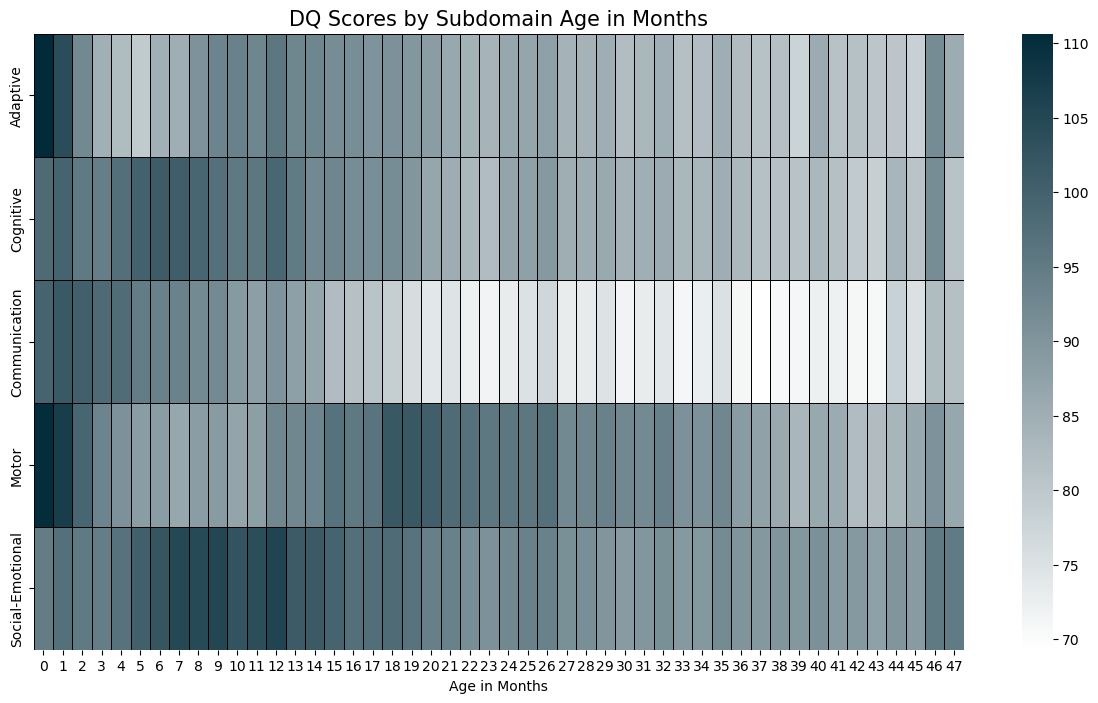

In [31]:
cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', ['#FFFFFF', '#022B3A'])

pivot_df = heat.pivot_table(index="Age in Months", values=dq_list_2, aggfunc='mean')

plt.figure(figsize=(15, 8))

sns.heatmap(pivot_df.T, annot=False, cmap=cmap, linewidths=0.5, linecolor='black')
plt.title('DQ Scores by Subdomain Age in Months', fontsize=15)

plt.show()

### Line Graph of DQ by Age

In [32]:
df_dq = df[['Adaptive Developmental Quotient', 'Cognitive Developmental Quotient', 'Communication Developmental Quotient', 'Motor Developmental Quotient', 'Social-Emotional Developmental Quotient', 'months']]

In [33]:
avg_sub_by_age = df_dq.groupby('months')[['Adaptive Developmental Quotient', 
                                      'Cognitive Developmental Quotient', 
                                      'Communication Developmental Quotient', 
                                      'Motor Developmental Quotient', 
                                      'Social-Emotional Developmental Quotient']].mean()

#avg_sub_by_age

In [40]:
avg_sub_by_age = avg_sub_by_age.reset_index()

In [41]:
avg_sub_by_age = avg_sub_by_age.rename(columns={'months':'Age in Months'})

In [66]:
#avg_sub_by_age

In [43]:
avg_sub_by_age = avg_sub_by_age
avg_sub_by_age = avg_sub_by_age[avg_sub_by_age['Age in Months']<48]
#avg_sub_by_age.head()

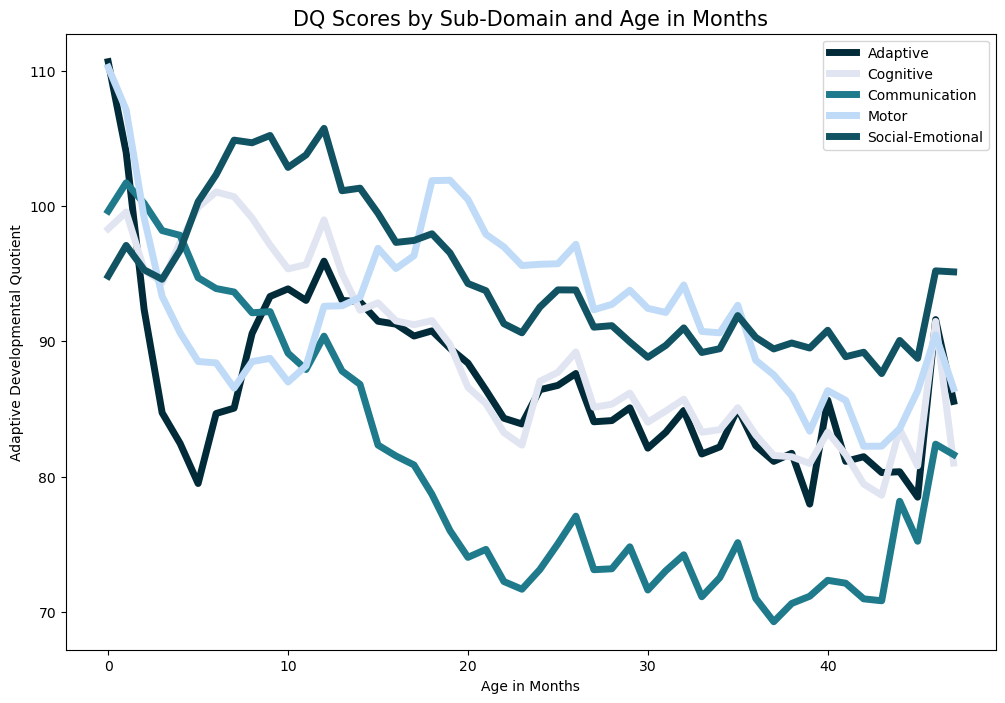

In [44]:
plt.figure(figsize=(12, 8))

sns.lineplot(data=avg_sub_by_age, x='Age in Months', y='Adaptive Developmental Quotient', label='Adaptive', color='#022B3A', linewidth=5)
sns.lineplot(data=avg_sub_by_age, x='Age in Months', y='Cognitive Developmental Quotient', label='Cognitive', color='#E1E5F2', linewidth=5)
sns.lineplot(data=avg_sub_by_age, x='Age in Months', y='Communication Developmental Quotient', label='Communication', color='#1F7A8C', linewidth=5)
sns.lineplot(data=avg_sub_by_age, x='Age in Months', y='Motor Developmental Quotient', label='Motor', color='#BFDBF7', linewidth=5)
sns.lineplot(data=avg_sub_by_age, x='Age in Months', y='Social-Emotional Developmental Quotient', label='Social-Emotional', color='#115363', linewidth=5)

plt.title('DQ Scores by Sub-Domain and Age in Months', fontsize=15)

plt.show()

## 6. Is there any difference in scoring noted based on evaluation type?

In [45]:
bdi_by_program_label = bdi_df.groupby('Program Label')['BDI-3 Total Developmental Quotient'].mean().reset_index(name='Avg_BDI')
bdi_by_program_label

,Program Label,Avg_BDI
0,BDI-3 Annual Evaluation,84.951853
1,BDI-3 Eligibility Evaluation,89.299264
2,BDI-3 Milestone or Exit Evaluation,85.870206


In [47]:
# Barplot
#plt.figure(figsize=(16, 10))
#sns.barplot(data=bdi_by_program_label, x='Avg_BDI', y='Program Label')
#plt.title('Average BDI by Program Label');

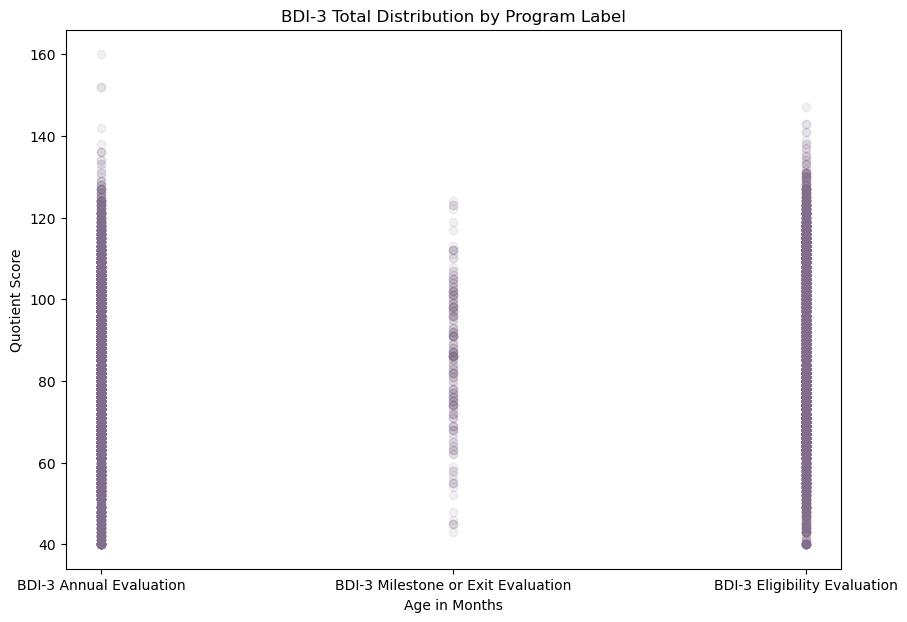

In [48]:
plt.figure(figsize=(10, 7))

plt.scatter(df['Program Label'], df['BDI-3 Total Developmental Quotient'], label='BDI-3 Total', c='#826d8c', alpha=0.1)

plt.title('BDI-3 Total Distribution by Program Label')
plt.xlabel('Age in Months')
plt.ylabel('Quotient Score')

plt.show()

In [50]:
dq_list = [col for col in df.columns if 'Quotient' in col]
dq = df[dq_list]
#dq.head()

In [51]:
dq = pd.concat([general, dq], axis=1)

In [53]:
#dq.sort_values('BDI-3 Total Developmental Quotient', ascending=False)

In [54]:
dq_avg = dq.groupby('Program Label')[dq_list].mean()

In [56]:
#dq_avg

### Separate by Eval Type

In [57]:
eligibility= df[df['Program Label'] == 'BDI-3 Eligibility Evaluation']
annual = df[df['Program Label'] == 'BDI-3 Annual Evaluation']
exit = df[df['Program Label'] == 'BDI-3 Milestone or Exit Evaluation']

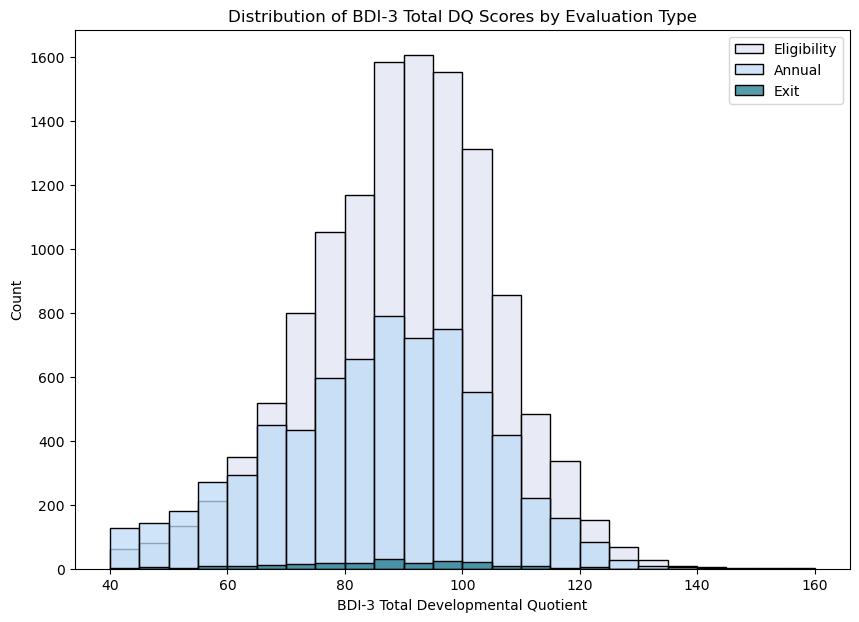

In [58]:
plt.figure(figsize=(10, 7))

sns.histplot(eligibility['BDI-3 Total Developmental Quotient'], color='#E1E5F2', label='Eligibility', binwidth=5)
sns.histplot(annual['BDI-3 Total Developmental Quotient'], color='#BFDBF7', label='Annual', binwidth=5)
sns.histplot(exit['BDI-3 Total Developmental Quotient'], color='#1F7A8C', label='Exit', binwidth=5, binrange=(40, 140))

#plt.yscale('log')  
plt.title('Distribution of BDI-3 Total DQ Scores by Evaluation Type')
plt.xlabel('BDI-3 Total Developmental Quotient')
plt.legend()
plt.show()

In [60]:
df.groupby(['Program Label', 'Eligibility'])['Eligibility'].count()

Program Label                       Eligibility 
BDI-3 Annual Evaluation             25% delay        838
                                    40% delay       1515
                                    not eligible    4531
BDI-3 Eligibility Evaluation        25% delay       1431
                                    40% delay       1452
                                    not eligible    9473
BDI-3 Milestone or Exit Evaluation  25% delay         34
                                    40% delay         35
                                    not eligible     134
Name: Eligibility, dtype: int64

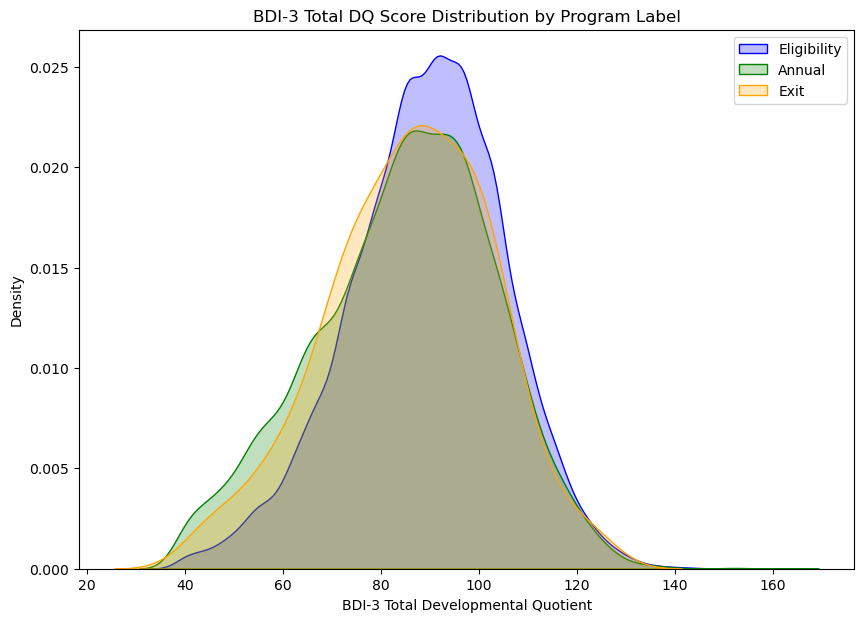

In [61]:
plt.figure(figsize=(10, 7))

sns.kdeplot(data=eligibility['BDI-3 Total Developmental Quotient'], fill=True, label='Eligibility', color='blue')
sns.kdeplot(data=annual['BDI-3 Total Developmental Quotient'], fill=True, label='Annual', color='green')
sns.kdeplot(data=exit['BDI-3 Total Developmental Quotient'], fill=True, label='Exit', color='orange')

plt.legend()
plt.title('BDI-3 Total DQ Score Distribution by Program Label')

plt.show()

In [62]:
df.groupby('Program Label')['Program Label'].count()

Program Label
BDI-3 Annual Evaluation                6904
BDI-3 Eligibility Evaluation          12391
BDI-3 Milestone or Exit Evaluation      203
Name: Program Label, dtype: int64

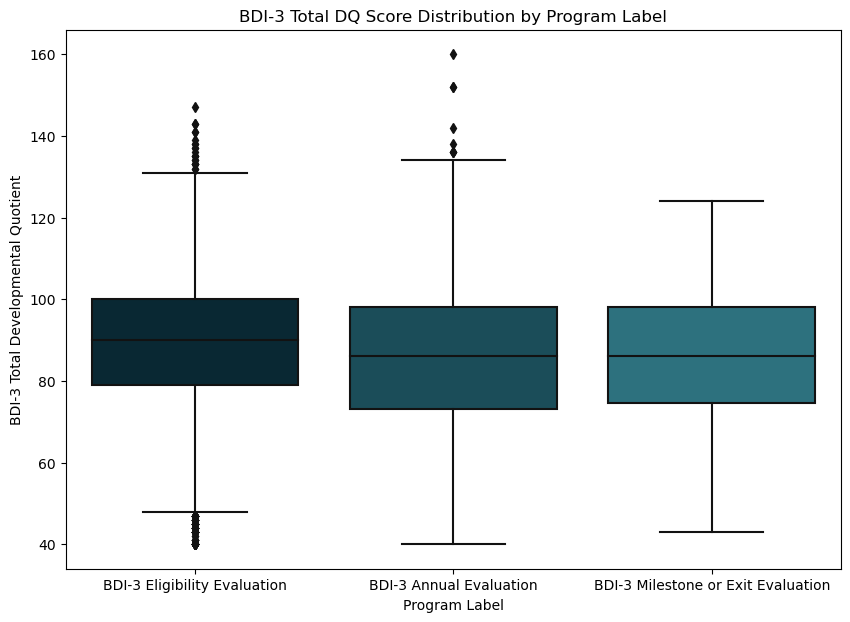

In [64]:
plt.figure(figsize=(10, 7))

df['Program Label'] = pd.Categorical(df['Program Label'], categories=['BDI-3 Eligibility Evaluation', 'BDI-3 Annual Evaluation', 'BDI-3 Milestone or Exit Evaluation'], ordered=True)

colors = ['#022B3A', '#115363', '#1F7A8C'] 

sns.boxplot(data=df, x='Program Label', y='BDI-3 Total Developmental Quotient', palette=colors)

plt.title('BDI-3 Total DQ Score Distribution by Program Label')

plt.show()